In [1]:
!pip install matplotlib
!pip install sympy

In [2]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle 

# **The cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient, and $F:|F|\leq 10\,\text{N}$ is the force applied to cart's center of mass.

# 1.   Clearly define the state vector $x$ and the control input vector $u$. Define also the domains to which they belong, $X$ and $U$ respectively.

The state vector  is:
$$
x = \left( \begin{array}{ccc}
                \theta \\
                \dot \theta \\
                p_c \\
                \dot p_c
\end{array} \right)
=
\left( \begin{array}{ccc}
                  x_1 \\
                  x_2 \\
                  x_3 \\
                  x_4
\end{array} \right)
$$

Where:
- $\theta$ is the angular position
- $\dot \theta$ is the angular velocity
- $p_c$ is the linear position
- $\dot p_c$ is the linear velocity


The control input  is the force applied to the cart: $u = F$ with the constraint that $|u| < 10$.

All the variables $x_1,... , x_4,u \in \mathbb{R}$, respectively $X = \mathbb{R}^4$ and $U = \mathbb{R}$.

# 2.   Compute the equilibrium state $\bar{x}$ when the control input $\bar{u}$ is set equal to $0$.



To calculate the equilibrium state, I have to solve the state equation when I are already at an equilibrium state and see that this state doesn't change. Since I am dealing with an understandable physical syste, I can assume the equilibrium state to be $(0,0,0,0)$, when the applied $F=0$. Let's check this

In [3]:
g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

# let's set the input force to 0
F = 0 # N

In [4]:
from scipy.optimize import fsolve
from math import exp
from numpy import sin, cos

def equations(vars):
    x1, x2, x3, x4 = vars
    d_x1 = x2
    d_x2 = (g*sin(x1)+ cos(x1)*((-F-m*l*(x2**2)*sin(x1))/(mc+m))-((miup*x2)/(m*l))) / (l*((4/3)-((m*(cos(x1)**2))/(mc+m))))

    d_x3 = x4
    d_x4 = (F+m*l*((x2**2)*sin(x1)-d_x2*cos(x1)))/(mc+m)

    return [d_x1, d_x2, d_x3, d_x4]

x1, x2, x3, x4 =  fsolve(equations, (0, 0, 0, 0))

print(x1, x2, x3, x4)

0.0 0.0 0.0 0.0


It was found that the state is not changing, so this is indeed an equilibrium state.

# 3.   Given the sequence of control inputs $\left[u^{(0)},\,u^{(1)},\cdots,u^{(100)}\right]=\left[\right]$ simulate the behavior of the non linear system $(*)$



The steps that will be executed will be:
1. load the data
2. simulate the system
3. plot the state

In [5]:
uvec = loadmat('U.mat')
uvec = uvec['U'][0]

The following function will describe the dynamic:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

In [6]:
def cart_and_pole_odeint(x, t, F):
  dxdt = np.zeros_like(x)

  dxdt[0] = x[1] #tetap
  dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
  dxdt[2] = x[3] #xp
  dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
  return dxdt

In [7]:
time_step=0.02
t0_odeint=0
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])
X_odeint=[x0_odeint]

To simulate the system the integral between two consecutive time instants is being calculated using the function odeint

In [8]:
for i in range(len(uvec)):
    t1_odeint = t0_odeint+0.02
    t_odeint = np.array([t0_odeint, t1_odeint])
    F = uvec[i]
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)

Text(0.5, 1.0, 'dot p_c(t)')

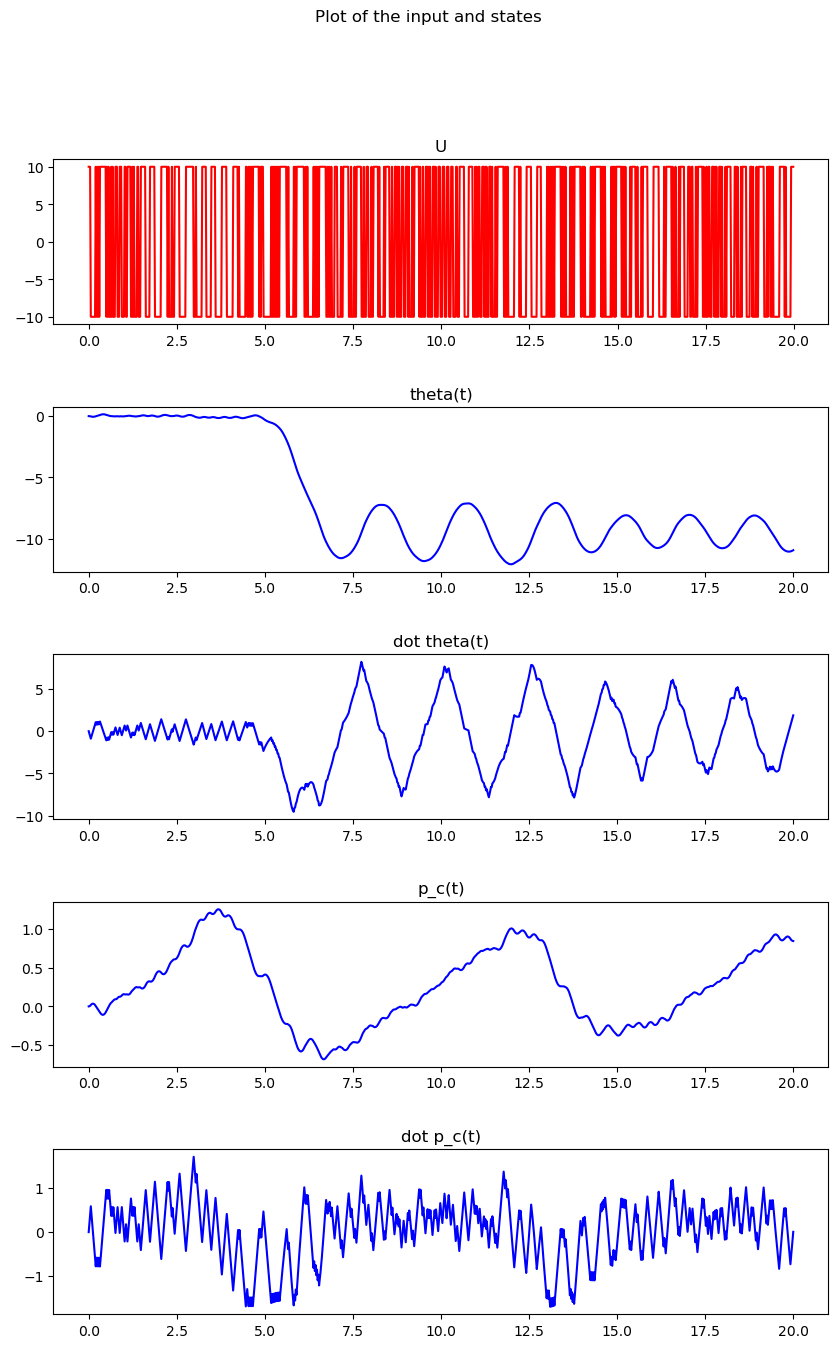

In [9]:
time_sim=np.arange(0.0, 20, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

fig.suptitle("Plot of the input and states")

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(np.arange(0.0, 20+time_step, time_step), X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(np.arange(0.0, 20+time_step, time_step), X_odeint[:,1], 'b')
axs[2].set_title("dot theta(t)")

axs[3].plot(np.arange(0.0, 20+time_step, time_step), X_odeint[:,2], 'b')
axs[3].set_title("p_c(t)")

axs[4].plot(np.arange(0.0, 20+time_step, time_step), X_odeint[:,3], 'b')
axs[4].set_title("dot p_c(t)")

# 4.   Given the non linear system (∗) linearize it around the equilibrium point computed in the point 2 and simulate the behavior of the linear systems given the same sequence of control inputs of point 3.

To linearize the system, I will make use of symbolic calculation. I have to replace the variables on the state equation and then derive (Taylor's series) each of them and substitute all the variables that I already know, since I'm already at an equilibrium state.

In [10]:
import sympy as sym
from sympy import sin, cos

In [11]:
x1 = sym.Symbol("x1")
x2 = sym.Symbol("x2")
x3 = sym.Symbol("x3")
x4 = sym.Symbol("x4")
F = sym.Symbol("F")
x = [x1,x2,x3,x4]
xeq = [0,0,0,0]
ueq = 0

In [12]:
theta2p = ((g*sin(x[0]))+(cos(x[0])*((-F-(m*l*(x[1]**2)*sin(x[0])))/(mc+m)))-((miup*x[1])/(m*l)))/(l*((4/3)-((m*((cos(x[0]))**2))/(mc+m))))
x2p = (F+(m*l*(((x[1]**2)*sin(x[0]))-((((g*sin(x[0]))+(cos(x[0])*((-F-(m*l*(x[1]**2)*sin(x[0])))/(mc+m)))-((miup*x[1])/(m*l)))/(l*((4/3)-((m*((cos(x[0]))**2))/(mc+m)))))*cos(x[0])))))/(mc+m)

I first linearize the components for the A matrix, then the B matrix.

In [13]:
theta2p_linA = []
for i in range(len(x)):
    lin = sym.diff(theta2p, x[i]) # evaluate the partial derivative
    lin = lin.subs(F, ueq)
    for j in range(len(x)):
        lin = lin.subs(x[j], xeq[j]) # replace equilibrium points
    theta2p_linA.append(lin)
theta2p_linA

[15.7756097560976, -6.43902439024390e-5, 0, 0]

In [14]:
theta2p_linB = sym.diff(theta2p, F)
for j in range(len(x)):
    theta2p_linB = theta2p_linB.subs(x[j], xeq[j]) # replace equilibrium points
theta2p_linB

-1.46341463414634

In [15]:
x2p_linA = []
for i in range(len(x)):
    lin = sym.diff(x2p, x[i]) # evaluate the partial derivative
    lin = lin.subs(F, ueq)
    for j in range(len(x)):
        lin = lin.subs(x[j], xeq[j]) # replace equilibrium points
    x2p_linA.append(lin)
x2p_linA

[-0.717073170731708, 2.92682926829268e-6, 0, 0]

In [16]:
x2p_linB = sym.diff(x2p, F)
for j in range(len(x)):
    x2p_linB = x2p_linB.subs(x[j], xeq[j]) # replace equilibrium points
x2p_linB

0.975609756097561

Here in the lines 7-9 and 14-16, the linear system is being reconstructed

In [17]:
def cart_and_pole_lin(x, t, F):
    dxdt = np.zeros_like(x)

    dxdt[0] = x[1] #tetap
    
    dxdt[1] = 0 #teta2p
    for i in range(len(x)):
        dxdt[1] += theta2p_linA[i]*(x[i] - xeq[i])
    dxdt[1] += theta2p_linB * (F - ueq)
    
    dxdt[2] = x[3] #xp
    
    dxdt[3] = 0 #x2p
    for i in range(len(x)):
        dxdt[3] += x2p_linA[i]*(x[i] - xeq[i])
    dxdt[3] += x2p_linB * (F - ueq)
    
    return dxdt

In [18]:
linearized_model = {
    "theta2p_linA": theta2p_linA,
    "theta2p_linB": theta2p_linB,
    "x2p_linA": x2p_linA,
    "x2p_linB": x2p_linB
}
with open('linearized_model.pkl', 'wb') as file: 
    pickle.dump(linearized_model, file) 

In [19]:
time_step=0.02
t0_odeint=0
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])
X_odeint=[x0_odeint]

In [20]:
for i in range(len(uvec)):
  t1_odeint = t0_odeint+0.02
  t_odeint = np.array([t0_odeint, t1_odeint])
  F = uvec[i]
  x_odeint = odeint(cart_and_pole_lin, x0_odeint, t_odeint, args=(F, ))
  x0_odeint = x_odeint[1]
  X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)

Text(0.5, 1.0, 'dot p_c(t)')

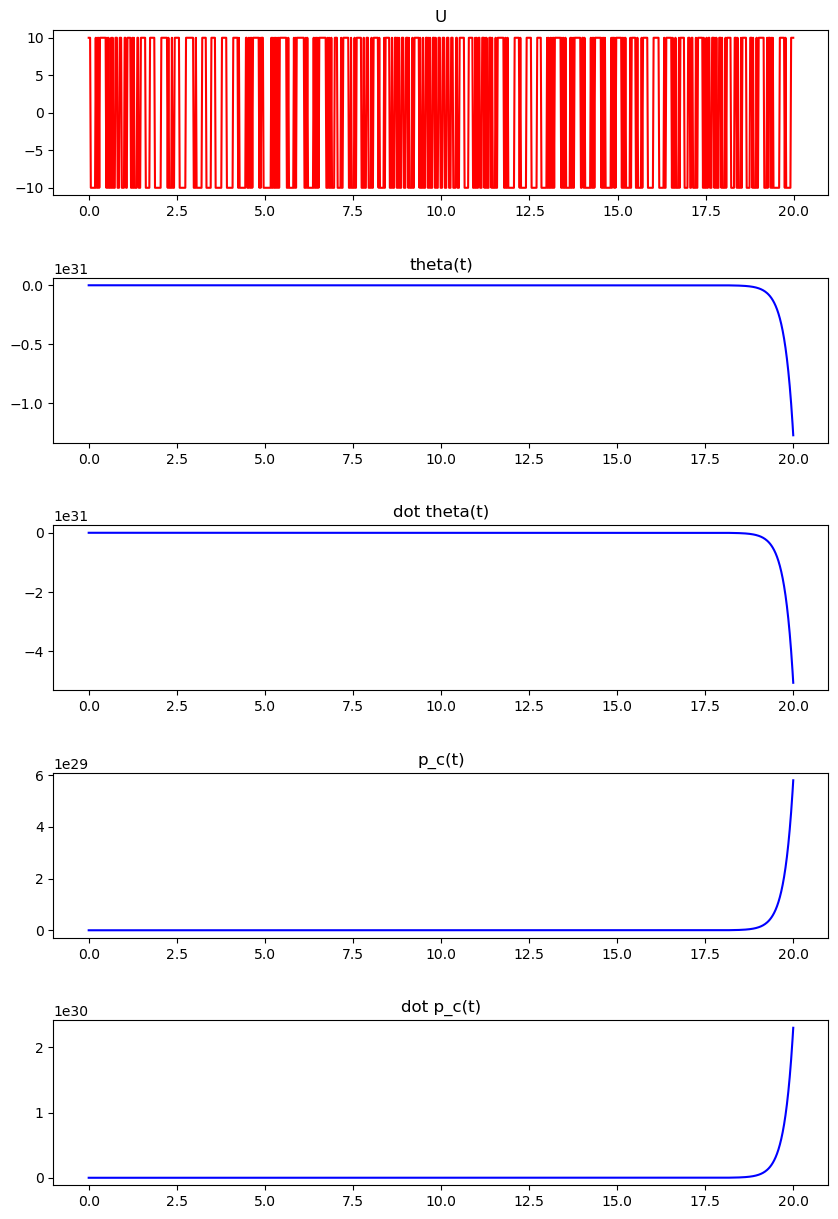

In [21]:
time_sim=np.arange(0.0, 20, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(np.arange(0.0, 20+time_step, time_step), X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(np.arange(0.0, 20+time_step, time_step), X_odeint[:,1], 'b')
axs[2].set_title("dot theta(t)")

axs[3].plot(np.arange(0.0, 20+time_step, time_step), X_odeint[:,2], 'b')
axs[3].set_title("p_c(t)")

axs[4].plot(np.arange(0.0, 20+time_step, time_step), X_odeint[:,3], 'b')
axs[4].set_title("dot p_c(t)")

# 5.   Comment the results obtained in point 3 and 4. Do you observe any difference?



The gotten results at the points 3 and 4 are profoundly different and the main reason is that in the second case we are using a linearised system far away from it's equilibrium point and this will lead to unavoidable errors as we are moving away from the equilibrium. Supplying a $F=\pm 10$ is not the best to stay close to $(0,0,0,0)$.